In [1]:
##############     Parámetros    ##############
imageset = "g1_s50_n5" # g1_s25_n5, g1_s50_n5, g1_s75_n5

In [5]:
##############      Configuración      ##############
import os
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict
from PIL import Image
from dotenv import dotenv_values

pd.set_option('display.max_columns', None)
env = dotenv_values("globals_win.env")

path_proyecto   = env['PATH_PROYECTO']    
path_datain     = env['PATH_DATAIN']
path_dataout    = env['PATH_DATAOUT']
path_scripts    = env['PATH_SCRIPTS']    
path_satelites  = env['PATH_SATELITES']
path_logs       = env['PATH_LOGS']     
path_outputs    = env['PATH_OUTPUTS']     
# path_programas  = globales[7]

In [6]:
def add_img_to_df(df: pd.DataFrame, images: List[str], columnas: List[str], sample_size: int = 5, format: str = '.jpg') -> pd.DataFrame:
    ''' Agrega links con las imagenes al dataframe. 
        
        Si hay más de un tipo, duplica la observación para que cada observación 
        tenga una imagen de cada tipo. Elimina las observaciones que no tiene imagen.
        
        Args:
        - df: dataframe con las observaciones
        - images: lista con las rutas de las imagenes. La ruta debe estar completa. Se espera que el nombre de la imagen tenga la
        siguiente estructura:
            - GMaps_{link}_{index}_{sample}{format}, por ejemplo, GMaps_021000432_875_4.jpg
        - sample_size: tamaño de la muestra. Si es None, no se toma muestra.
    '''
    def add_ESRI_GMaps(df, images, format, sample) -> pd.DataFrame:
        ''' Adds two columns to the df: ESRI_{sample} and GMaps_{sample}
            For reference, the path of the images is, for example:
                {path_datain}\\g1_s50_n5\\rural\\ESRI_020010101_15479_1.jpg, or
                {path_datain}\\g1_s50_n5\\urban\\ESRI_020010101_1257_4.jpg
        '''
        
        # Keep only the images of the sample
        images = [img for img in images if img.split('_')[-1].split('.')[0] == str(sample)]
        images = pd.Series(images)
        
        gmaps = images[images.str.contains('GMaps_')]
        gmaps_df = pd.DataFrame(
            {'link':  gmaps.str.split(r"\\").str[-1].str.replace('GMaps_', '').str[:9],
             'urban': gmaps.str.split(r"\\").str[-2] == "urban",
             f'GMaps_{sample}': gmaps,}
        )        
        esri = images[images.str.contains('ESRI_')]
        esri_df = pd.DataFrame(
            {'link':  esri.str.split(r"\\").str[-1].str.replace('ESRI_', '').str[:9],
             'urban': esri.str.split(r"\\").str[-2] == "urban",
             f'ESRI_{sample}': esri,}
        )
        
        images_df = gmaps_df.merge(esri_df, on=['link','urban'], how='outer', validate='1:1')
        df = df.merge(images_df, on=['link','urban'], how='left', validate='1:1')
        return df
    
    assert len(df)>0, "El dataframe no puede estar vacío."
    
    for sample in range(sample_size):
        sample = sample + 1
        df = add_ESRI_GMaps(df, images, format, sample)
        print(f'Se encontraron {df[f"ESRI_{sample}"].notna().sum()} imagenes de ESRI WI.')
        print(f'Se encontraron {df[f"GMaps_{sample}"].notna().sum()} imagenes de Google Maps.')
    
    # Duplica las observaciones que tienen más de una imagen
    esri_vars = [f"ESRI_{i}" for i in range(1, sample_size+1)]
    gmaps_vars = [f"GMaps_{i}" for i in range(1, sample_size+1)]    
    value_vars = esri_vars + gmaps_vars
    df = df.melt(id_vars=columnas, value_vars=value_vars, var_name="fuente", value_name="image")
    
    # Elimino el tamaño de muestra
    df['fuente'] = df['fuente'].apply(lambda x: x.split('_')[0])
    
    # Elimina las observaciones que no tienen imagen
    df = df.dropna(subset=["image"])

    return df

def resize_images(df: pd.DataFrame, size:int=512):
    out_list = []
    for i in df.image:
        image = Image.open(f"{i}")
        new_image = image.resize((size,size))
        name = i.split('\\')[-1]
        path_out = f"{path_dataout}/processed_images/{name}"
        new_image.save(path_out)
        out_list.append(path_out)
    
    df["image"] = out_list
    
    return df

def remove_outliers(df: pd.DataFrame, col: str):
    q_low = df[col].quantile(0.01)
    q_hi = df[col].quantile(0.99)
    df_filtered = df[(df[col] < q_hi) & (df[col] > q_low)]

    return df_filtered

In [7]:
# Base de indicadores full
df = gpd.read_feather(rf'{path_datain}\census_tracts_with_indicators.feather')
df['link'] = df['link'].astype(str).str.zfill(9)
df = df[df['AMBA_legal'] == 1]
print(df.dtypes)

index                 int64
link                 object
AREA                float64
PERIMETER           float64
PAISXRAD10            int64
                     ...   
pred_inc_mean       float32
ln_pred_inc_mean    float32
pred_inc_p50        float32
ln_pred_inc_p50     float32
urban                  bool
Length: 153, dtype: object


In [10]:
float = ['rmin', 'rmax', 'p_usd', 'pm2','icv2010', 'nbi_rc_val', 'icpag', 'indvilla', 'pred_inc_mean', 'pred_inc_p50']
integ =  ['personas', 'viv_part', 'codaglo']

for i in float:
    df[i] = pd.to_numeric(df[i], errors='coerce', downcast='float')
for i in integ:
    df[i] = pd.to_numeric(df[i], errors='coerce', downcast='integer')

# Normalizo el Indice de Calidad de Vida (icv2010)
df['icv2010'] = df['icv2010'] / 10

# Genero cuantiles de todos los indicadores --solo para urbanos
for col in ['icv2010', 'rmin', 'rmax', 'pred_inc_mean', 'pred_inc_p50']:
    df.loc[df.urban == True, col + '_c'] = pd.qcut(df.loc[df.urban == True, col], 101, labels=False) / 100
    df.loc[df.urban == True, col + '_d'] = pd.qcut(df.loc[df.urban == True, col], 10, labels=False) + 1 

# df = pd.get_dummies(df, columns=['rmax_d'])

print(df.dtypes)

index                int64
link                object
AREA               float64
PERIMETER          float64
PAISXRAD10           int64
                    ...   
rmax_d             float64
pred_inc_mean_c    float64
pred_inc_mean_d    float64
pred_inc_p50_c     float64
pred_inc_p50_d     float64
Length: 163, dtype: object


In [11]:
display(df.describe())

,index,AREA,PERIMETER,PAISXRAD10,PAISXRAD_1,PROV,DEPTO,FRAC,RADIO,link_dpto,eph_codagl,codaglo,aglo_eph,AMBA_legal,rmin,rmax,rminp50,rminp25,rminp75,rmaxp50,rmaxp25,rmaxp75,p_usd,pm2,obs_pm2,pm2_2019,obs_pm2_19,p_usd_2019,personas,viv_part,lvp1bvp50,lvpra_1bvp,lvprf_1bvp,lvp1bv,lvpra_1bv,lvprf_1bv,superficie,den_p,rural1,rural2,urbano,mergelvp,objectid_1,cod_fra,provdep,oid_,objectid,link_1,cod_fra_1,provdep_1,indicetmi,rrbn,rrsc,pa_complem,varon,mujer,totalpobl,poblnoasis,poblmenpri,f_edmen1ri,indedmen1r,univcompl,f_edunv,indeduniv,pobhogpart,hacinam,f__hacinam,indhacinam,sinretrete,f__sinretr,indsinretr,poblsinobr,inundsi,inundno,inundtotal,basusi,basuno,basutotal,villasi,villano,villatotal,var¥n,mujer1,totalpob_1,f_pobinund,f_pobbasu,f_pobvilla,indinund,indbasu,indvilla,indpa,p1305,link2,f_sobsocia,indobsoc,icv2010,mergeicv,cprov,nprov,CicvNr,CicvNp,CicvNv,CrmaxNr,CrmaxNp,CrmaxNv,Crmaxp50Nr,Crmaxp50Np,Crmaxp50Nv,Crmaxp25Nr,Crmaxp25Np,Crmaxp25Nv,Crmaxp75Nr,Crmaxp75Np,Crmaxp75Nv,CicvPr,CicvPp,CicvPv,CrmaxPr,CrmaxPp,CrmaxPv,Crmaxp50Pr,Crmaxp50Pp,Crmaxp50Pv,Crmaxp25Pr,Crmaxp25Pp,Crmaxp25Pv,Crmaxp75Pr,Crmaxp75Pp,Crmaxp75Pv,tasa_activ,tasa_emple,tasa_desoc,total,total_val,con_nbi,sin_nbi,nbi_rc,nbi_rc_val,icpagNabs,CicpagNv,icpag,pred_inc_mean,ln_pred_inc_mean,pred_inc_p50,ln_pred_inc_p50,icv2010_c,icv2010_d,rmin_c,rmin_d,rmax_c,rmax_d,pred_inc_mean_c,pred_inc_mean_d,pred_inc_p50_c,pred_inc_p50_d
count,16442.000000,1.644200e+04,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,15451.000000,15449.000000,16442.000000,16442.0,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,1.137500e+04,11375.000000,13844.000000,9427.000000,12355.000000,9.659000e+03,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,1.644200e+04,16442.000000,16442.000000,16442.000000,16442.000000,16442.0,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,1.644200e+04,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,1.524000e+04,16442.000000,16442.000000,16442.000000,16442.0,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,16442.000000,15052.000000,15052.000000,15052.000000,15052.000000,15052.000000,15052.000000,15052.000000,15052.000000,15052.000000,15052.000000
mean,8163.838219,1.481180e+06,2928.142058,34953.112699,34953.116470,5.134655,362.956271,18.536735,6.851174,5497.611422,1.075400,1.281895,0.939728,1.0,0.669217,0.406850,0.701212,0.800314,0.569966,0.405173,0.547238,0.263490,1.429275e+05,1354.736572,12.025209,1687.475270,11.925617,1.808671e+05,901.462717,311.342659,11.168796,11.169868,11.155362,11.164154,11.165133,11.150650,1.484241e+06,118.683361,0.006924,0.023595,0.969481,3.0,7697.744313,549779.678932,5497.611422,18649.654969,18650.654969,5.497797e+07,549779.678932,5497.611422,0.820962,2.868660,6.847103,5.802457,389.251794

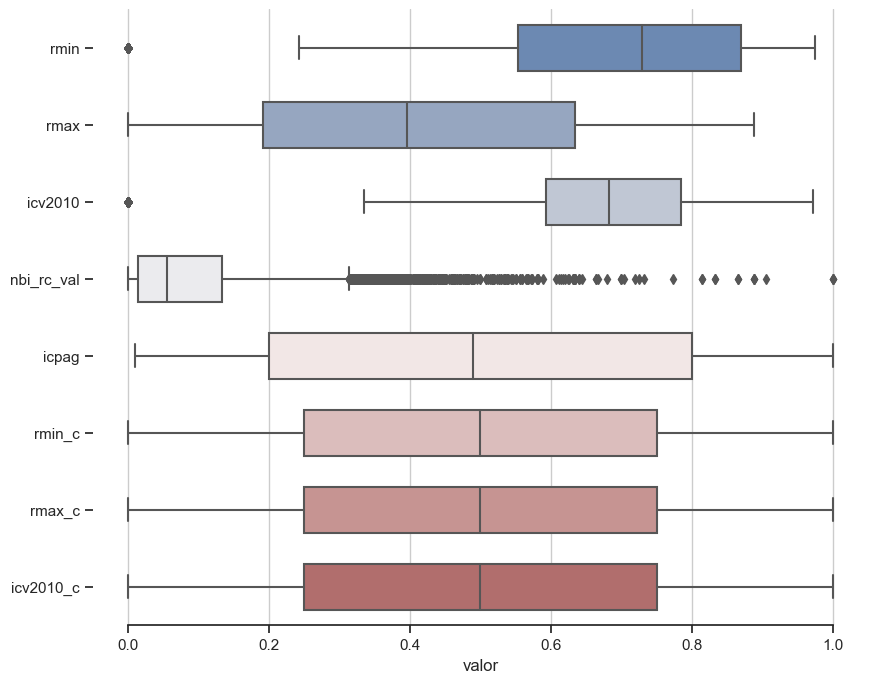

In [12]:
# Grafico los indicadores numéricos
sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(10, 8))

plot_data = df.melt(
    id_vars='link', 
    value_vars=['rmin', 'rmax','icv2010', 'nbi_rc_val', 'icpag', 'rmin_c', 'rmax_c','icv2010_c'], 
    var_name='variable', value_name='valor'
    )

# Plot the indexes with horizontal boxes
sns.boxplot(data=plot_data, x="valor", y="variable",
            width=.6, palette="vlag", ax=ax)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

In [13]:
def tree_lister(root, only='.jpg'):
    import os
    filelist = []
    
    for root, dirs, files in os.walk(root):

        for f in files:

            if only in f:
                filelist += [os.path.join(root, f)]
        
    return filelist
path_images = rf"R:\Tesis Nico\Códigos\data\data_in\{imageset}"
images = tree_lister(path_images)

(6279345.591766179, 6440326.011744155, 6075393.624760978, 6256897.400227575)

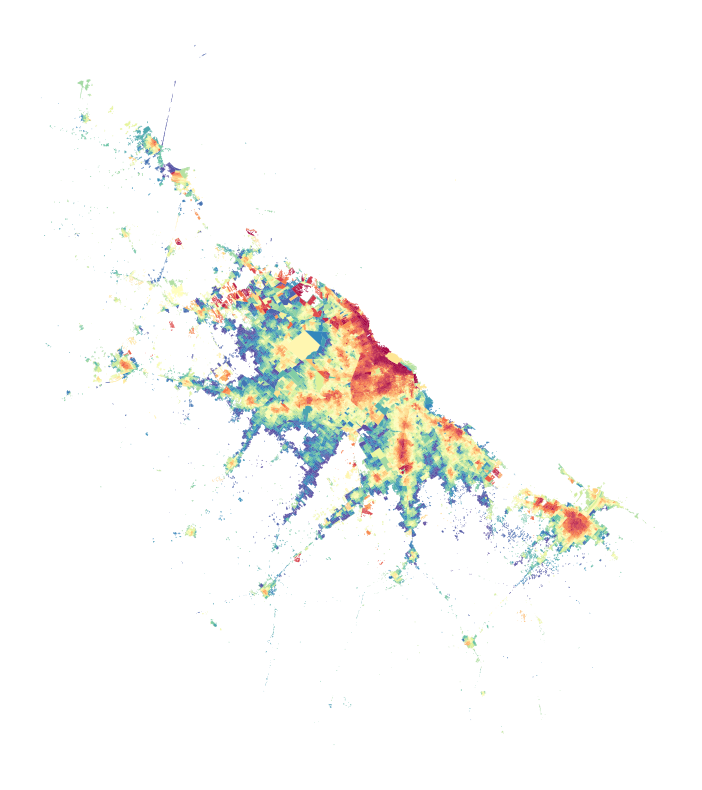

In [18]:
df.plot(column='rmax_c', cmap='Spectral_r', edgecolor="face", linewidth=0.1, figsize=(10,10))
plt.axis('off')


<Axes: ylabel='Density'>

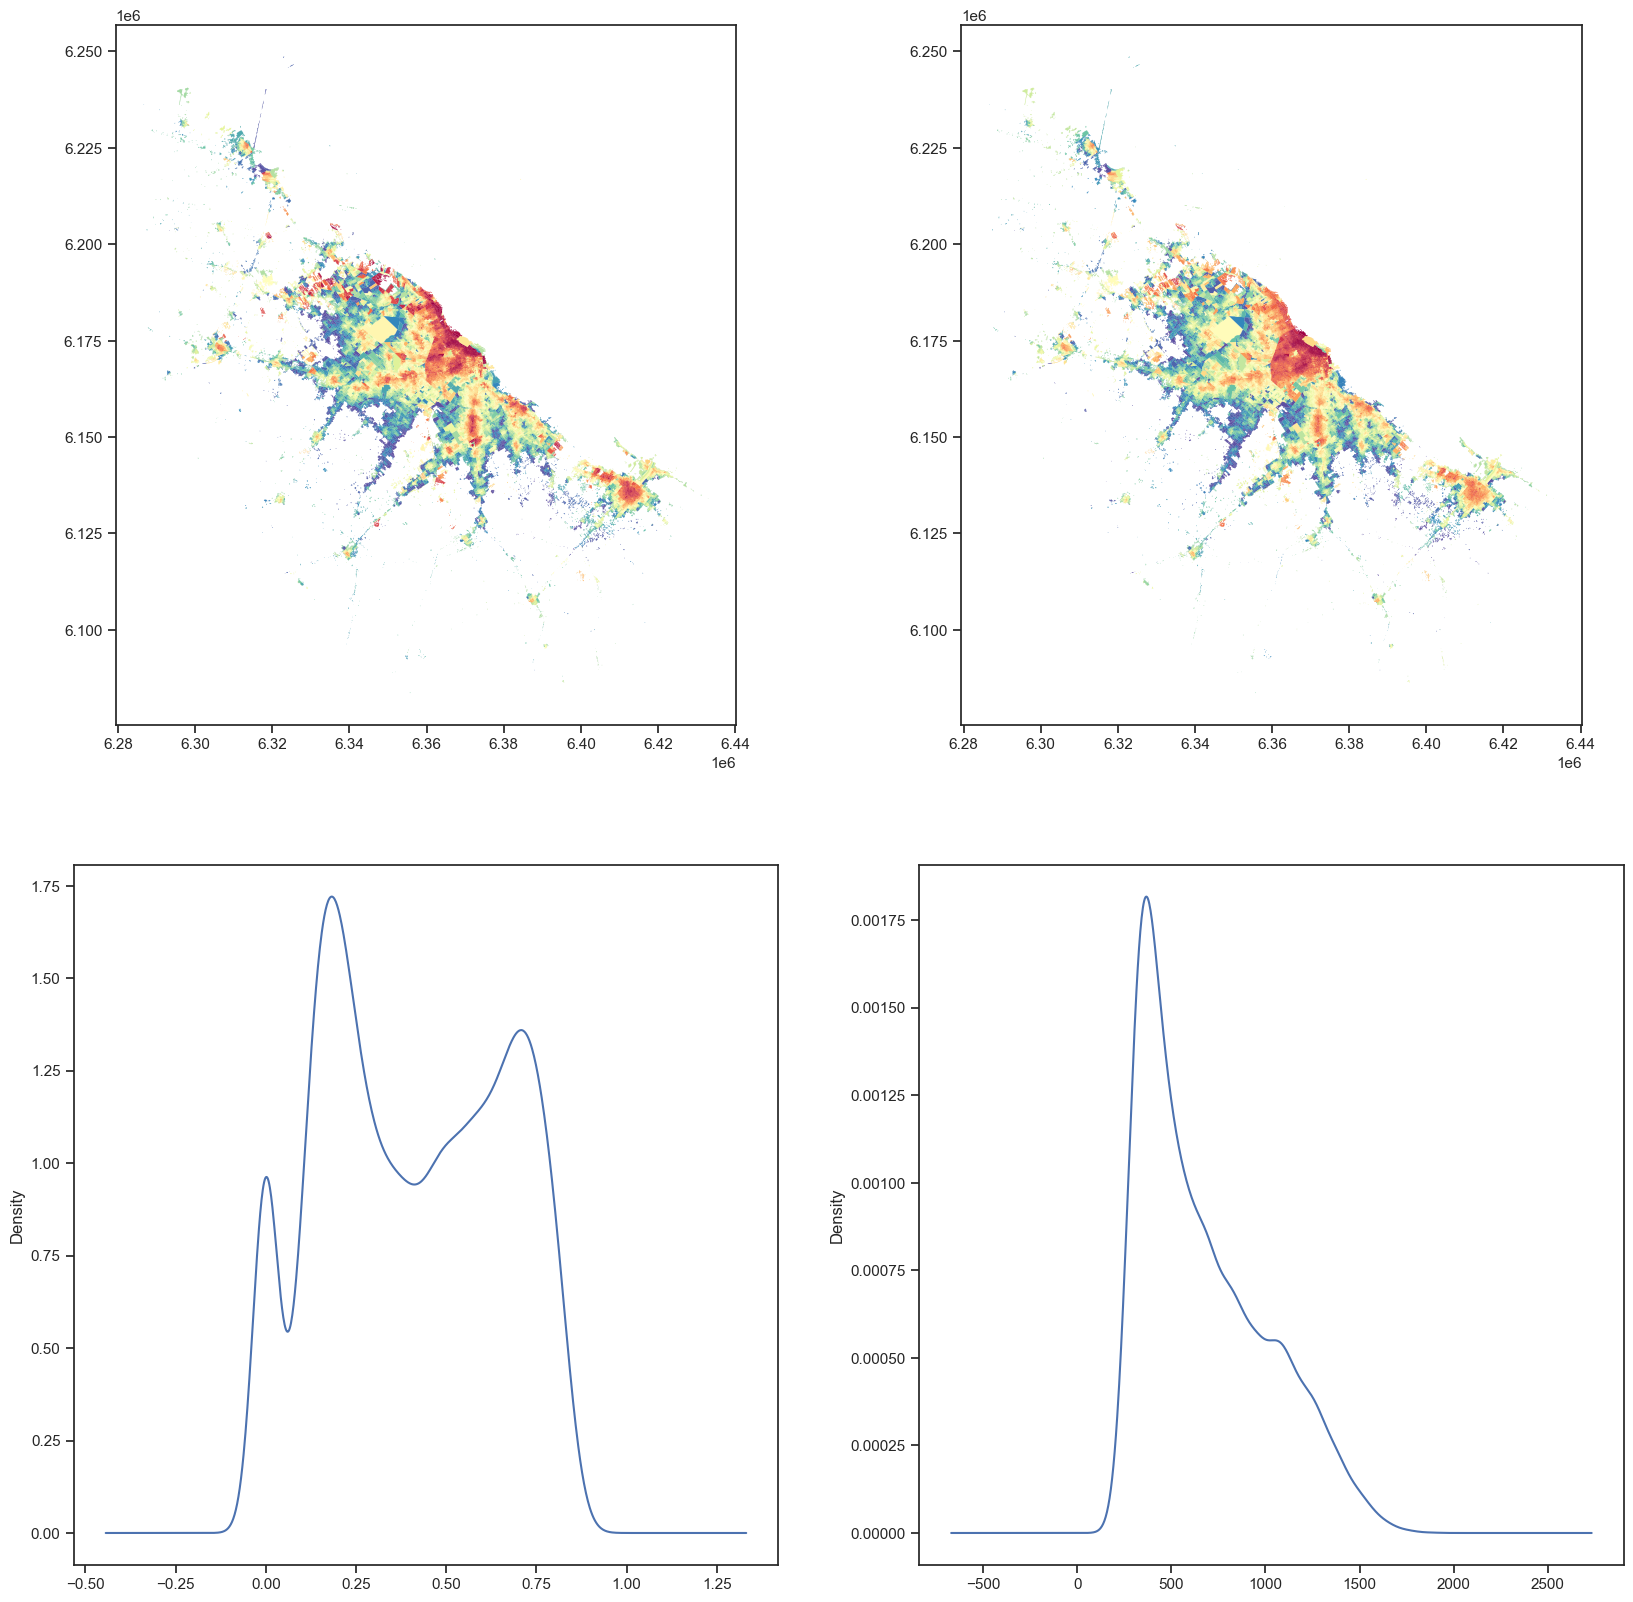

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(20,20), dpi=100)
df.plot(column='rmax_c', cmap='Spectral_r', edgecolor="face", linewidth=0.1, ax=axs[0][0])
df.plot(column='pred_inc_p50_c', cmap='Spectral_r', edgecolor="face", linewidth=0.1, ax=axs[0][1])
df.rmax.plot(kind='kde', ax=axs[1][0])
df.pred_inc_p50.plot(kind='kde', ax=axs[1][1])

In [187]:
# images = os.listdir(f"R:\Tesis Nico\Códigos\data\data_in\Imagenes descargadas")
# images = os.listdir(f"{path_datain_new}")
columnas = [
    'link', 'provincia', 'eph_codagl','eph_aglome', 'codaglo',
    'aglomerado','aglo_eph','AMBA_legal','urban','rmin','rmax','p_usd',
    'pm2','personas','viv_part','indvilla', 'icv2010', 'nbi_rc_val',
    'icpag','rmax_c','rmax_d','icv2010_d', 'rmin_d',
    'pred_inc_p50']

df = add_img_to_df(df, images, columnas, sample_size=5)
df['image'] = df['image'].str.replace('\\', '/')

Se encontraron 15858 imagenes de ESRI WI.
Se encontraron 16055 imagenes de Google Maps.
Se encontraron 15871 imagenes de ESRI WI.
Se encontraron 16042 imagenes de Google Maps.
Se encontraron 15875 imagenes de ESRI WI.
Se encontraron 16052 imagenes de Google Maps.
Se encontraron 15866 imagenes de ESRI WI.
Se encontraron 16067 imagenes de Google Maps.
Se encontraron 15859 imagenes de ESRI WI.
Se encontraron 16054 imagenes de Google Maps.


C:\Users\Administrador\AppData\Local\Temp\ipykernel_28280\3610160330.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['image'] = df['image'].str.replace('\\', '/')


In [188]:
# Exporto base
df = df.sort_values(by='image')
df.to_parquet(fr'{path_dataout}\dataset_amba_{imageset}.parquet')

C:\Users\Administrador\AppData\Local\Temp\ipykernel_28280\1783462216.py:3: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  df.to_parquet(fr'{path_dataout}\dataset_amba_{imageset}.parquet')


In [189]:
%tensorboard

UsageError: Line magic function `%tensorboard` not found.
